# ARIMA на исторических

In [4]:
from alex.database import Database # вспомогательный класс для подключения к базе и работе с sql
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import pandas as pd
from decimal import Decimal
%matplotlib inline
from pprint import pprint

In [5]:
# stat packages
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf # функция расчёта автокорреляций
from statsmodels.graphics.tsaplots import plot_acf # визуализация автокорреляций
from statsmodels.tsa.stattools import adfuller # Расширенный тест Дики-Фуллера
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot

In [6]:
import seaborn as sns 
sns.set_style("whitegrid")
import altair as alt # пакет визуализации Altair
alt.renderers.enable('notebook')
alt.data_transformers.enable('csv')

DataTransformerRegistry.enable('csv')

In [7]:
db = Database() # подключение к базе данных с учётными данными для Alex

## Загрузка истории

In [8]:
exchange = "binance"
pair = "ETH/USDT"
lag_seconds = 86400*7 #- 1 day

sql = f"select id, dt, price, amount, side from tvf_get_history_seconds_ago({lag_seconds}) order by dt, id"
history = db.query(sql)
# history = db.optimize_df(db.query(sql))

In [9]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1937360 entries, 0 to 1937359
Data columns (total 5 columns):
id        float64
dt        datetime64[ns]
price     float64
amount    float64
side      object
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 73.9+ MB


In [10]:
#history.index = pd.to_datetime(history['dt'])
#del history['dt']
history.set_index('dt', inplace=True)
history.side.astype('category')
history['volume'] = history.price * history.amount

### Фильтрация исходного набора

In [11]:
history_bak = history.copy()
#history = history[:int(len(history)/4)]
#history = history_bak.copy()

## Визуализация загруженных данных

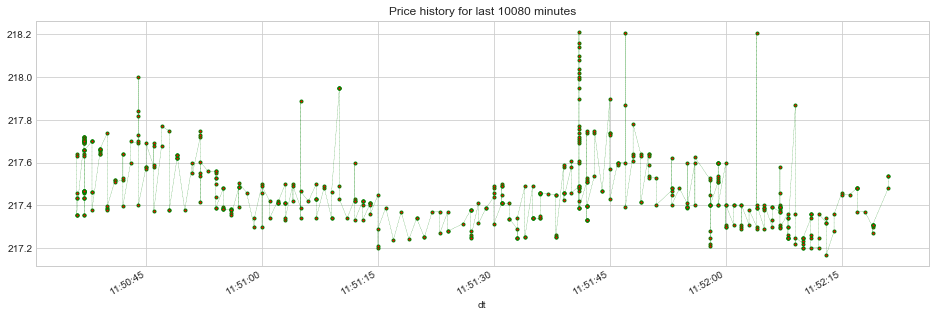

In [12]:
plt.rcParams['figure.figsize'] = [16, 5]
history['price'][-500:].plot(grid=True, marker='.', color='green', linestyle='--', 
                              linewidth=0.25, markerfacecolor='r')
plt.title(f"Price history for last {int(lag_seconds/60)} minutes")
plt.show()

## Мин, макс, среднее, медиана, стд.отклонение

In [13]:
h = history.describe()
mean = h.loc['mean', 'volume']
std = h.loc['std', 'volume']
median = h.loc['50%', 'volume']
low = h.loc['min', 'volume']
high= h.loc['max', 'volume']
print(f"среднее объёма = ${mean:.2f}\n"
      f"медиана объёма = ${median:.2f}\n"
      f"стандартное отклонение объёма = {std:.2f}\n"
      f"минимум объёма = ${low:.6f}\n"
      f"максимум объёма = ${high:.2f}")

среднее объёма = $453.70
медиана объёма = $56.39
стандартное отклонение объёма = 2530.43
минимум объёма = $0.000002
максимум объёма = $925504.71


In [14]:
h = history.describe()
mean = h.loc['mean', 'price']
std = h.loc['std', 'price']
median = h.loc['50%', 'price']
low = h.loc['min', 'price']
high= h.loc['max', 'price']
print(f"среднее цены = ${mean:.2f}\n"
      f"медиана цены = ${median:.2f}\n"
      f"стандартное отклонение цены = {std:.2f}\n"
      f"минимум цены = ${low:.6f}\n"
      f"максимум цены = ${high:.2f}")

среднее цены = $210.99
медиана цены = $204.08
стандартное отклонение цены = 13.47
минимум цены = $185.000000
максимум цены = $240.00


## Автокорреляция

In [15]:
def plot_price(x):
    plt.rcParams['figure.figsize'] = [16, 3]
    plt.plot(x, marker='.', color='gray', linestyle='--', linewidth=1, markerfacecolor='r')
    plt.show()

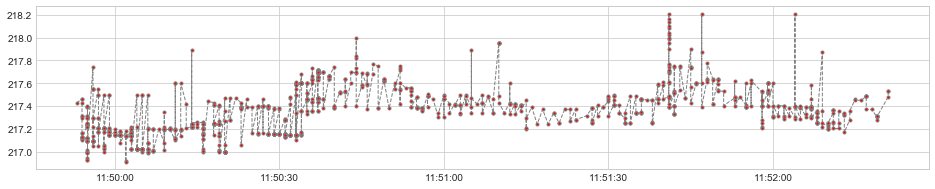

In [16]:
plot_price(history.price[-1000:])

Справочно: очень высокая автокорреляция соседних абсолютных значений цены

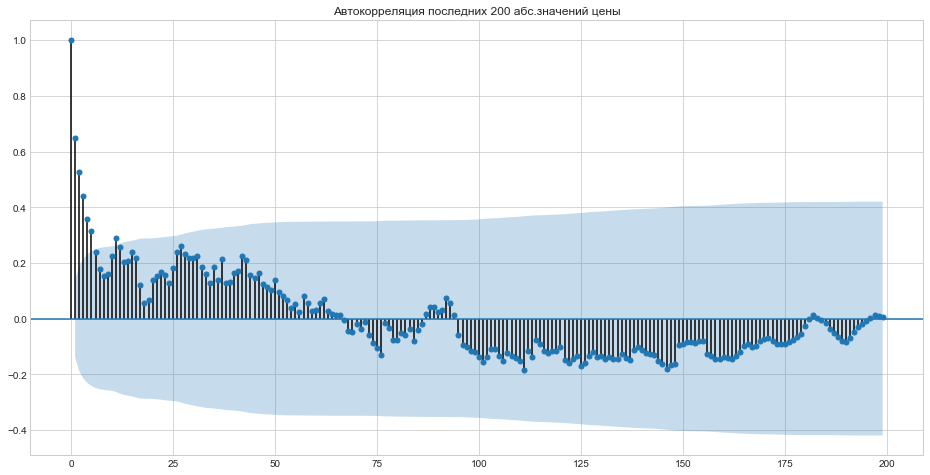

In [17]:
plt.rcParams['figure.figsize'] = [16, 8]
_ = plot_acf(history.price[-200:], title="Автокорреляция последних 200 абс.значений цены", alpha=0.05)

<b>Доверительный интервал</b> в 95% [1 - alpha] обозначен голубым конусом. Значения корреляций ВНЕ этого конуса показывают, что это не просто статистический выброс.<br/><br/>
Корелограмма медленно убывает по синусоиде, что косвенно указывает на нестационарность ряда

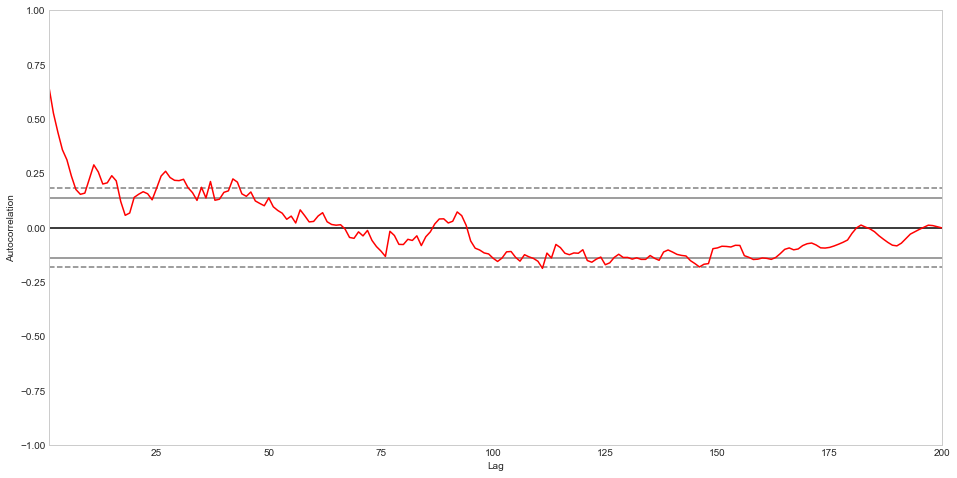

In [18]:
# второй вариант, используется встроенный в pandas autocorrelation_plot
plt.rcParams['figure.figsize'] = [16, 8]
autocorrelation_plot(history.price[-200:], color='r')
plt.show()

## Конвертация в OHLC

In [19]:
interval = 1 # minutes
df = history[['price', 'amount']].resample(str(interval)+'min').ohlc()

In [20]:
df.head()

price                                        amount  \
                           open        high         low       close      open   
dt                                                                              
2018-10-08 11:52:00  224.910004  225.069305  224.910004  224.963593  0.086990   
2018-10-08 11:53:00  224.963593  225.812408  224.426712  224.732056  0.001172   
2018-10-08 11:54:00  225.000000  225.149994  224.732056  225.036407  0.355660   
2018-10-08 11:55:00  225.036407  225.160004  224.929199  225.054398  0.006000   
2018-10-08 11:56:00  225.054398  225.812485  224.732056  225.009995  0.007000   

                                                    
                          high       low     close  
dt                                                  
2018-10-08 11:52:00  53.514942  0.002172  0.004828  
2018-10-08 11:53:00  11.989180  0.000172  3.509935  
2018-10-08 11:54:00   7.025000  0.000140  0.006000  
2018-10-08 11:55:00  71.910172  0.000170  0.007000  
2018-10-08 11:56:00  11.753300  0.006000  0.006000

In [21]:
df.shape

(10081, 8)

In [22]:
autocorrelation = df.price.close.autocorr(lag=1)
confidence = 1.96 / np.sqrt(len(df))
print(f"Автокорреляция по {interval}-минутным интервалам = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорреляция по 1-минутным интервалам = 99.98%
Приблизительный доверительный интервал = +/- 0.0195


In [23]:
autocorrelation = df.price.close.pct_change().autocorr()
confidence = 1.96 / np.sqrt(len(df))
print(f"Автокорреляция по {interval}-минутным интервалам изменения по {interval}-мин интервалу = {autocorrelation*100:.2f}%")
print(f"Приблизительный доверительный интервал = +/- {confidence:.4f}")

Автокорреляция по 1-минутным интервалам изменения по 1-мин интервалу = 13.47%
Приблизительный доверительный интервал = +/- 0.0195


## Сезонность (разные лаги)

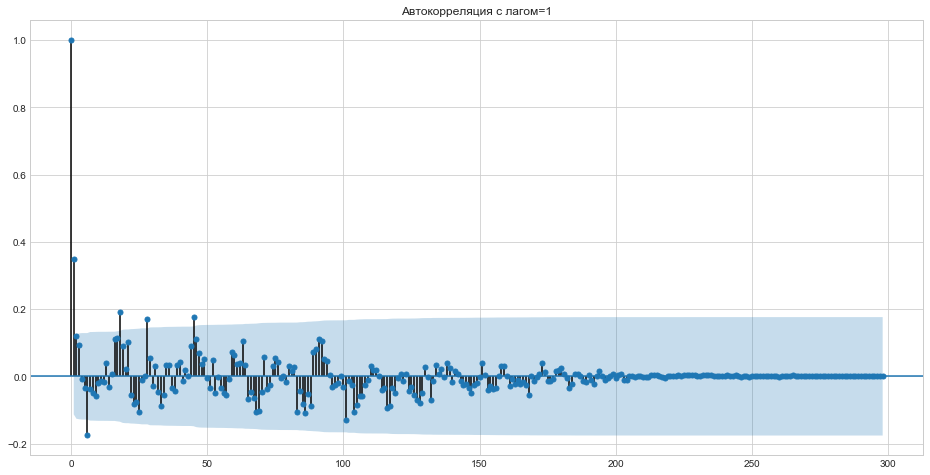

In [24]:
lag = 1
#df_lag = df.tail(300).price.close.pct_change().diff(lag).dropna()
df_lag = df.tail(300).price.close.diff(lag).dropna()
plt.rcParams['figure.figsize'] = [16, 8]
plot_acf(df_lag, title=f"Автокорреляция с лагом={lag}")
plt.show()


## ARIMA

In [25]:
# исходный набор, на котором тестируем ARIMA
df.price.tail()

,open,high,low,close
dt,,,,
2018-10-15 11:48:00,218.285599,218.950226,216.793411,218.000000
2018-10-15 11:49:00,217.800003,218.130005,216.929993,217.145996
2018-10-15 11:50:00,217.169998,218.000000,216.910004,217.339905
2018-10-15 11:51:00,217.500000,218.210007,217.199997,217.403793
2018-10-15 11:52:00,217.600006,218.206131,217.168900,217.535904


In [26]:
# Примерно 10000 строк, минутная разбивка
df.price.close.describe()

count    10078.000000
mean       211.232596
std         13.755844
min        189.060593
25%        199.897400
50%        202.301453
75%        226.879101
max        237.974106
Name: close, dtype: float64

In [27]:
# train/test split

starting = int(1440*3.8/interval)
split_point = int(1440*5/interval) # 3 days
ending = int(1440*6/interval)

train = df.fillna(method='ffill').iloc[starting:split_point,:] #head(split_point)
test = df.fillna(method='ffill').iloc[split_point:ending,:]
df_pct = df.price.close.iloc[starting:ending].diff().dropna(how='all')

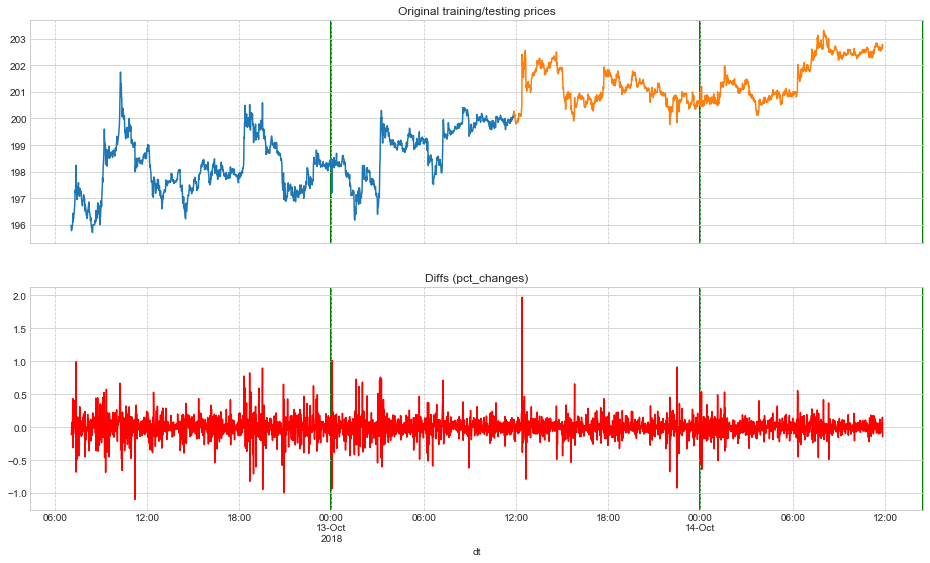

In [28]:
# xticks = pd.date_range(start=train.index.min(), end=train.index.max(), freq='15min')
days = dates.DayLocator()
hours = dates.HourLocator()
dfmt = dates.DateFormatter('%H:%M')

plt.rcParams['figure.figsize'] = [16, 9]
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
ax0, ax1 = axes

ax0.grid(True, which='minor', linestyle='--')
ax0.grid(True, which='major', axis='x', color='g', linewidth=2)
ax1.grid(True, which='major', axis='x', color='g', linewidth=2)
ax1.xaxis.set_major_locator(days)
ax1.xaxis.set_minor_formatter(dfmt)
ax1.xaxis.set_minor_locator(hours)
ax1.grid(True, which='minor', axis='x', linestyle='--')

train.price.close.plot(ax=ax0, title="Original training/testing prices")
test.price.close.plot(ax=ax0)
df_pct.plot(ax=ax1, color='r', title="Diffs (pct_changes)")
plt.show()

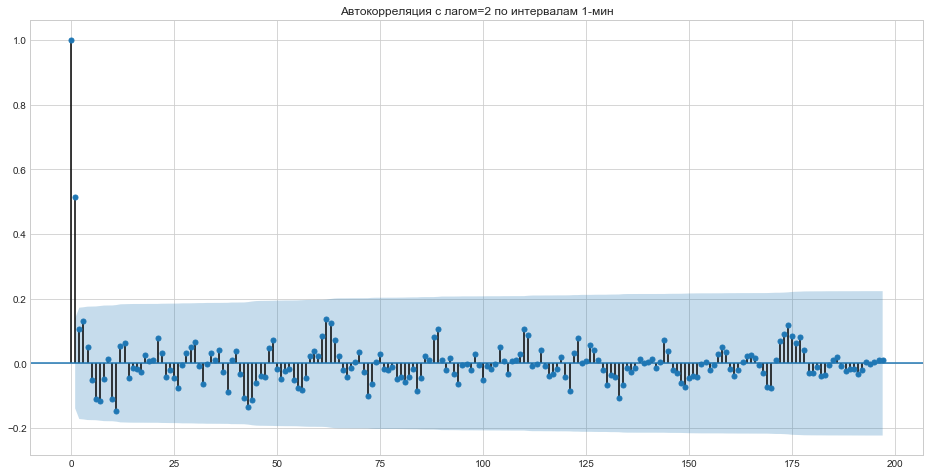

In [29]:
lag = 2

df_lag = train.price.close.head(200).diff(lag).dropna()
plt.rcParams['figure.figsize'] = [16, 8]
plot_acf(df_lag, title=f"Автокорреляция с лагом={lag} по интервалам {interval}-мин")
plt.show()

## SARIMAX

In [30]:
exog = sm.add_constant(train.price.close) #[-1:] + test.price.close[0:])

In [31]:
# ARIMA model init
p,d,q = 1,1,1
#model = ARMA(train.price.close, order=(p, q))
#model = ARIMA(train.price.close, order=(p,d,q))
model = SARIMAX(train.price.close, order=(p,d,q), trend='t', 
                seasonal_order=(0,1,1,12), mle_regression=True,
                enforce_stationarity=True, enforce_invertibility=False)

In [32]:
result = model.fit(disp=False)

C:\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [33]:
print(result.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              close   No. Observations:                 1728
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 342.538
Date:                            Mon, 15 Oct 2018   AIC                           -675.077
Time:                                    11:52:46   BIC                           -647.841
Sample:                                10-12-2018   HQIC                          -664.999
                                     - 10-13-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       5.339e-08   2.09e-06      0.026      0.980   -4.05e-06    4.15e-06
ar.L1         -0.0692      0.298   

In [34]:
start = pd.to_datetime(train.index[0]).strftime('%Y-%m-%d %H:%M:%S')
end = pd.to_datetime(train.index[-1]).strftime('%Y-%m-%d %H:%M:%S')
start, end

('2018-10-12 07:04:00', '2018-10-13 11:51:00')

In [35]:
forecast0 = result.forecast()[0]
fact_price = test.price.close[0]
error = (forecast0/fact_price-1)*100
print(f"Next {interval}-min forecast: {forecast0}, actual: {fact_price}, error: {error:.2f}%")

Next 1-min forecast: 200.23628704233556, actual: 200.1645965576172, error: 0.04%


In [36]:
# вычисляем предсказания - вычисленная линейная компонента
predictions = result.predict(start=d, end=len(train)+len(test)) #, typ='levels')
predict = result.get_prediction(start=len(train), end=len(train)+len(test))
#predictions[end:].head(5)
predict.predicted_mean.tail(5)

2018-10-14 11:48:00    219.271028
2018-10-14 11:49:00    219.252465
2018-10-14 11:50:00    219.305575
2018-10-14 11:51:00    219.319331
2018-10-14 11:52:00    219.395603
Freq: T, dtype: float64

In [37]:
# вычисляем out-of-sample прогноз
forecasts = result.forecast(steps=len(test))

In [38]:
forecast = pd.DataFrame(list(zip(test.price.close.index[:len(forecasts)], forecasts)), 
             columns=['dt', 'forecast']).set_index('dt')['forecast']
forecast.head()

dt
2018-10-13 11:52:00    200.236287
2018-10-13 11:53:00    200.227583
2018-10-13 11:54:00    200.210375
2018-10-13 11:55:00    200.179663
2018-10-13 11:56:00    200.208882
Name: forecast, dtype: float64

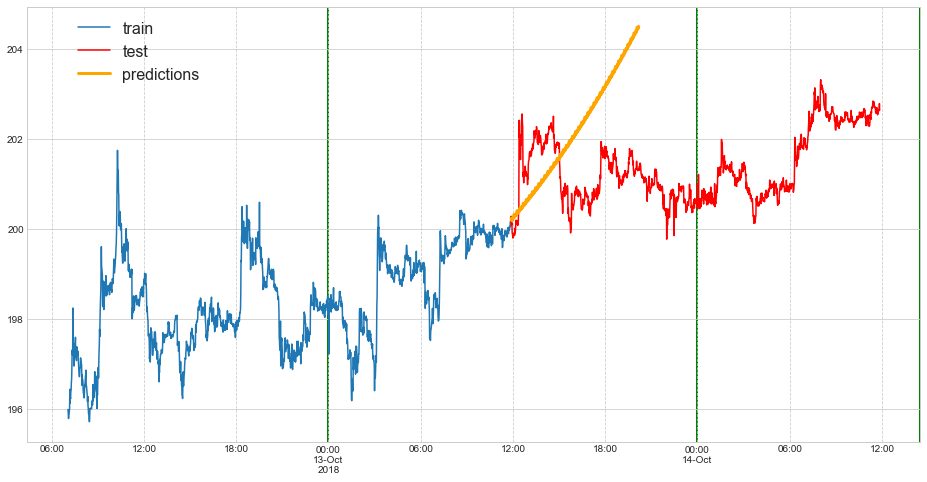

In [39]:
fig, ax = plt.subplots()
train.price.close.plot(ax=ax)
test.price.close.plot(color='r', ax=ax)
ax.grid(True, which='minor', linestyle='--')
ax.grid(True, which='major', axis='x', color='g', linewidth=2)
#fig = result.plot_predict(start=end, end=len(train)+len(test), dynamic=True, plot_insample=False, ax=ax)
#predictions[end:].head(500).plot(color='g', linewidth=2)
#forecast.plot(color='orange', linewidth=2, ax=ax)
predict.predicted_mean.head(500).plot(color='orange', linewidth=3)
ax.legend(['train', 'test', 'predictions', 'confidence'], prop={'size': 16}, 
          loc='upper left', bbox_to_anchor=(0.04, 1))
ax.set(xlabel='')
plt.show()

Неплохой прогноз на следующие 6 часов. (p=d=q=1), сезонность=(0,1,1,12). 
Сезонность явно не работает. Возможно, слишком большой интервал вперёд.

In [40]:
predict.predicted_mean.tail(10)

2018-10-14 11:43:00    219.126921
2018-10-14 11:44:00    219.170711
2018-10-14 11:45:00    219.182295
2018-10-14 11:46:00    219.223709
2018-10-14 11:47:00    219.224131
2018-10-14 11:48:00    219.271028
2018-10-14 11:49:00    219.252465
2018-10-14 11:50:00    219.305575
2018-10-14 11:51:00    219.319331
2018-10-14 11:52:00    219.395603
Freq: T, dtype: float64

In [41]:
train.tail(10)

price                                        amount  \
                           open        high         low       close      open   
dt                                                                              
2018-10-13 11:42:00  199.916397  200.019394  199.870102  199.897202  0.007200   
2018-10-13 11:43:00  199.870499  200.009995  199.850006  199.890503  0.007200   
2018-10-13 11:44:00  199.892899  200.170303  199.850006  200.035202  0.007200   
2018-10-13 11:45:00  200.022797  200.156403  199.880005  199.961807  0.300000   
2018-10-13 11:46:00  199.961807  200.182999  199.936203  199.975693  0.007200   
2018-10-13 11:47:00  199.985703  200.164597  199.946396  199.999298  0.007200   
2018-10-13 11:48:00  200.045502  200.154495  200.035507  200.052704  0.007200   
2018-10-13 11:49:00  200.053894  200.190002  200.000000  200.046799  0.007200   
2018-10-13 11:50:00  200.046799  200.310699  200.000000  200.161804  0.007200   
2018-10-13 11:51:00  200.307800  200.500000  199.990005  200.177002  0.077533   

                                                     
                           high       low     close  
dt                                                   
2018-10-13 11:42:00    1.699900  0.000010  0.383613  
2018-10-13 11:43:00   15.037400  0.001028  0.007200  
2018-10-13 11:44:00   10.656200  0.000010  0.007200  
2018-10-13 11:45:00   13.710900  0.000595  0.040351  
2018-10-13 11:46:00   72.227119  0.000635  0.020613  
2018-10-13 11:47:00   74.940636  0.000200  0.019077  
2018-10-13 11:48:00  147.096634  0.000820  0.007200  
2018-10-13 11:49:00   10.413600  0.004000  0.007200  
2018-10-13 11:50:00  208.944839  0.003927  0.007200  
2018-10-13 11:51:00   14.695990  0.000002  0.007200

## Pyramid ARIMA

In [42]:
import pyramid
print(f"pyramid version: {pyramid.__version__}")

pyramid version: 0.8.1


In [43]:
from pyramid.arima import ARIMA as pARIMA

In [44]:
fit = pARIMA(order=(1,1,1), seasonal_order=(1,1,1,12)).fit(y=train.price.close)

In [45]:
print(fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 1728
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 525.467
Date:                            Mon, 15 Oct 2018   AIC                          -1038.934
Time:                                    11:52:55   BIC                          -1006.251
Sample:                                         0   HQIC                         -1026.840
                                           - 1728                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.536e-05      0.000     -0.203      0.839      -0.000       0.000
ar.L1         -0.1753      0.160   

Интересно, что pyramid, видимо, частично базируется на коде statmodels - строится модель SARIMAX

In [46]:
# делаем датафрейм с out-of-sample предсказаниями sarimax:
predictions = pd.DataFrame(list(zip(test.price.close.index[:len(forecasts)], 
                                 fit.predict(n_periods=len(test)))), 
             columns=['dt', 'forecast']).set_index('dt')['forecast']

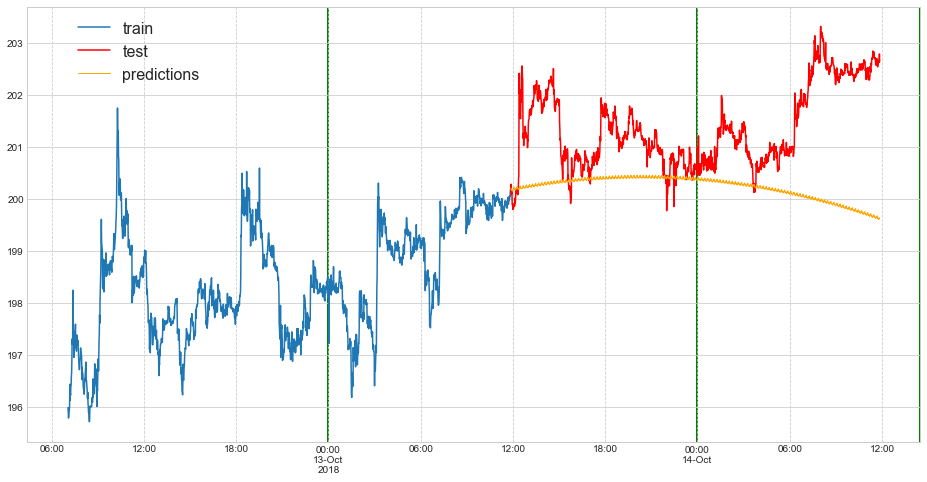

In [47]:
fig, ax = plt.subplots()
train.price.close.plot(ax=ax)
test.price.close.plot(color='r', ax=ax)
ax.grid(True, which='minor', linestyle='--')
ax.grid(True, which='major', axis='x', color='g', linewidth=2)
#fig = result.plot_predict(start=end, end=len(train)+len(test), dynamic=True, plot_insample=False, ax=ax)
#predictions[end:].head(500).plot(color='g', linewidth=2)
#forecast.plot(color='orange', linewidth=2, ax=ax)
#predict.predicted_mean.head(500).plot(color='orange', linewidth=3)
predictions.plot(color='orange', linewidth=1, ax=ax)
ax.legend(['train', 'test', 'predictions', 'confidence'], prop={'size': 16}, 
          loc='upper left', bbox_to_anchor=(0.04, 1))
ax.set(xlabel='')
plt.show()

Хреново

### Auto-ARMIA

In [48]:
from pyramid.arima import auto_arima

In [49]:
stepwise_fit = auto_arima(train.price.close, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          start_P=0, seasonal=True, d=1, D=1, trace=True,
                          error_action='ignore',  # don't want to know if an order does not work
                          suppress_warnings=True,  # don't want convergence warnings
                          stepwise=True)  # set to stepwise

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-1039.540, BIC=-1012.304, Fit time=5.493 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=56.666, BIC=67.560, Fit time=0.216 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=-451.092, BIC=-429.304, Fit time=2.076 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=-1041.097, BIC=-1019.308, Fit time=4.790 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=-1040.839, BIC=-1013.603, Fit time=6.572 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=36.048, BIC=52.389, Fit time=0.307 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=-1040.770, BIC=-1013.534, Fit time=19.125 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=-1038.142, BIC=-1005.459, Fit time=15.056 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=-1017.840, BIC=-1001.498, Fit time=3.729 seconds
Fit ARIMA: order=(0, 1

In [50]:
print(stepwise_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                 1728
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 524.549
Date:                            Mon, 15 Oct 2018   AIC                          -1041.097
Time:                                    11:54:11   BIC                          -1019.308
Sample:                                         0   HQIC                         -1033.034
                                           - 1728                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.081e-05      0.000     -0.206      0.837      -0.000       0.000
ma.L1         -0.1187      0.014   

Pyramid нашла лучшие параметры для SARIMAX для (p, d, q)x(сезонность) = (2, 1, 2)x(0, 1, 1, 12)

In [51]:
# делаем датафрейм с out-of-sample предсказаниями sarimax:
auto_arima =  pd.DataFrame(list(zip(test.price.close.index[:len(forecasts)], 
                                 stepwise_fit.predict(n_periods=len(test)))), 
             columns=['dt', 'forecast']).set_index('dt')['forecast']

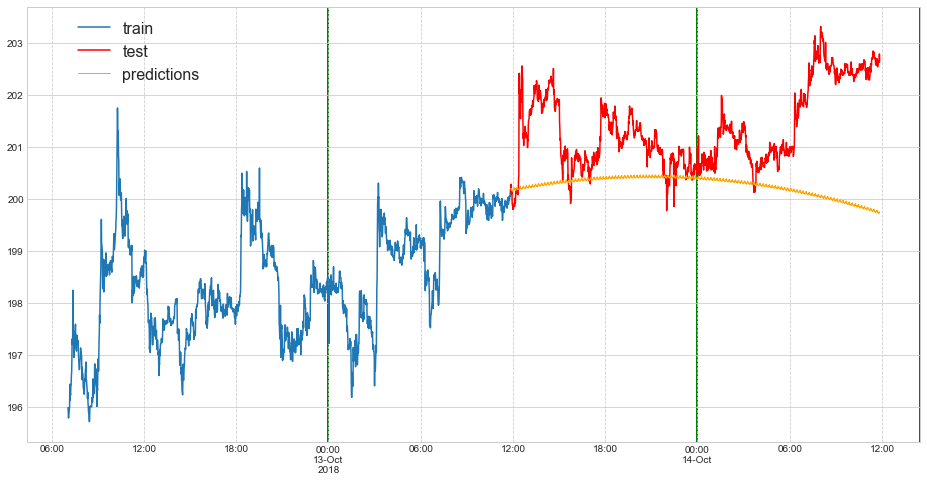

In [52]:
fig, ax = plt.subplots()

train.price.close.plot(ax=ax)
test.price.close.plot(color='r', ax=ax)

ax.grid(True, which='minor', linestyle='--')
ax.grid(True, which='major', axis='x', color='g', linewidth=2)
auto_arima.plot(color='orange', linewidth=1, ax=ax)

ax.legend(['train', 'test', 'predictions', 'confidence'], prop={'size': 16}, 
          loc='upper left', bbox_to_anchor=(0.04, 1))
ax.set(xlabel='')
plt.show()

Тоже хреново

### Использование внутреннего функционала Pyramid для вывода

In [53]:
from bokeh.plotting import figure, show, output_notebook
# init bokeh
output_notebook()

Loading BokehJS ...

In [64]:
def plot_arima(truth, forecasts, title="ARIMA", xaxis_label='Time',
               yaxis_label='Value', c1='#A6CEE3', c2='#B2DF8A', 
               forecast_start=None, **kwargs):
    
    # make truth and forecasts into pandas series
    n_truth = truth.shape[0]
    n_forecasts = forecasts.shape[0]
    
    # always plot truth the same
    truth = pd.Series(truth, index=np.arange(truth.shape[0]))
    
    # if no defined forecast start, start at the end
    if forecast_start is None:
        idx = np.arange(n_truth, n_truth + n_forecasts)
    else:
        idx = np.arange(forecast_start, n_forecasts)
    forecasts = pd.Series(forecasts, index=idx)
    
    # set up the plot
    p = figure(title=title, plot_height=400, **kwargs)
    p.grid.grid_line_alpha=0.3
    p.xaxis.axis_label = xaxis_label
    p.yaxis.axis_label = yaxis_label
    
    # add the lines
    p.line(truth.index, truth.values, color=c1, legend='train')
    p.line(len(truth)+test[:len(forecasts)-1].reset_index().index, test.price.close.values, color='orange', legend='test')
    p.line(forecasts.index, forecasts.values, color=c2, legend='forecasts')
    
    return p

In [65]:
show(plot_arima(train.price.close.values, stepwise_fit.predict(n_periods=100)))

C:\Anaconda3\lib\site-packages\bokeh\models\sources.py:110: BokehUserWarning: ColumnDataSource's columns must be of the same length. Current lengths: ('x', 99), ('y', 1440)
  "Current lengths: %s" % ", ".join(sorted(str((k, len(v))) for k, v in data.items())), BokehUserWarning))
